In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import detectron2
from detectron2.utils.logger import setup_logger
setup_logger()

import numpy as np
import cv2
import random
from detectron2 import model_zoo
from detectron2.engine import DefaultPredictor
from detectron2.config import get_cfg
from detectron2.utils.visualizer import Visualizer
from detectron2.data import MetadataCatalog

In [3]:
from data import to_coco

In [4]:
from detectron2.data import DatasetCatalog, MetadataCatalog
for d in ['train', 'val']:
    DatasetCatalog.register('cells_' + d, lambda d=d: to_coco(f'datasets/cells_{d}'))
    MetadataCatalog.get('cells_' + d).set(thing_classes=['cell'])
cell_metadata = MetadataCatalog.get('cells_train')

In [7]:
import matplotlib.pyplot as plt

In [ ]:
dataset_dicts = to_coco('datasets/cells_train')

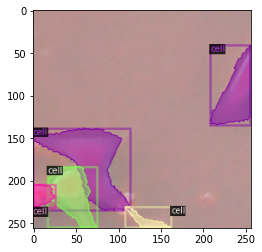

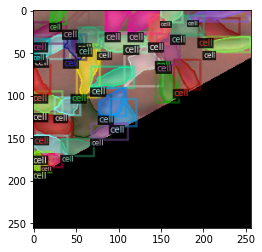

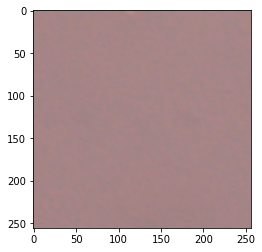

In [13]:
for d in random.sample(dataset_dicts, 3):
    img = cv2.imread(d["file_name"])
    visualizer = Visualizer(img[:, :, ::-1], metadata=cell_metadata, scale=1)
    vis = visualizer.draw_dataset_dict(d)
    plt.imshow(vis.get_image()[:, :, ::-1])
    plt.show()

In [14]:
from data import to_coco
import matplotlib.pyplot as plt

In [15]:
from detectron2.data import DatasetCatalog, MetadataCatalog
for d in ['train', 'val']:
    DatasetCatalog.register('cells_' + d, lambda d=d: to_coco(f'datasets/cells_{d}'))
    MetadataCatalog.get('cells_' + d).set(thing_classes=['cell'])
cell_metadata = MetadataCatalog.get('cells_train')

AssertionError: Dataset 'cells_train' is already registered!

In [16]:
cfg.MODEL.WEIGHTS = os.path.join(cfg.OUTPUT_DIR, "model_final.pth")
cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.7   # set the testing threshold for this model
cfg.DATASETS.TEST = ("cells_val", )
predictor = DefaultPredictor(cfg)

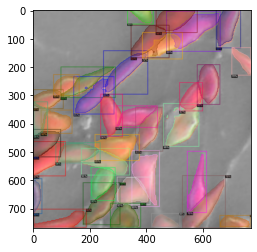

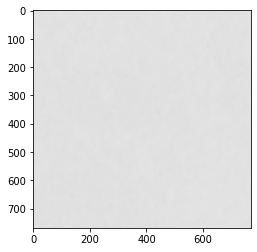

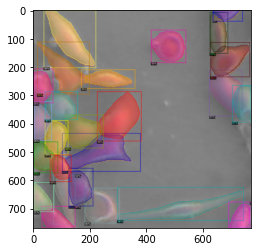

In [32]:
from detectron2.utils.visualizer import ColorMode
dataset_dicts = to_coco("datasets/cells_val")
for d in random.sample(dataset_dicts, 3):    
    im = cv2.imread(d["file_name"])
    outputs = predictor(im)
    v = Visualizer(im[:, :, ::-1],
                   metadata=cell_metadata, 
                   scale=3.0, 
                   instance_mode=ColorMode.IMAGE_BW   # remove the colors of unsegmented pixels
    )
    v = v.draw_instance_predictions(outputs["instances"].to("cpu"))
    plt.imshow(v.get_image()[:, :, ::-1])
    plt.show()

In [ ]:
from detectron2.utils.visualizer import ColorMode
dataset_dicts = to_coco("datasets/cells_val")

In [56]:
print(cell_metadata)

Metadata(name='cells_train', thing_classes=['cell'])


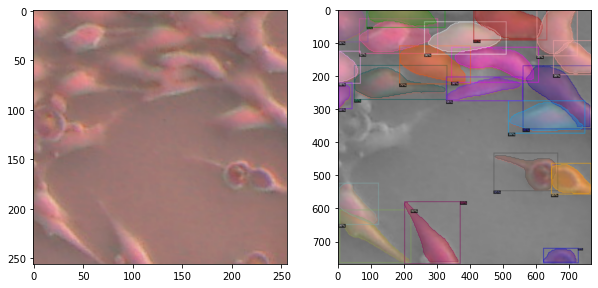

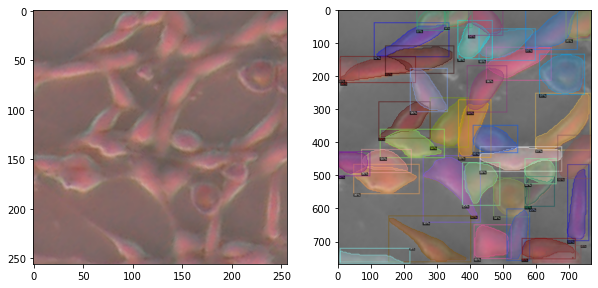

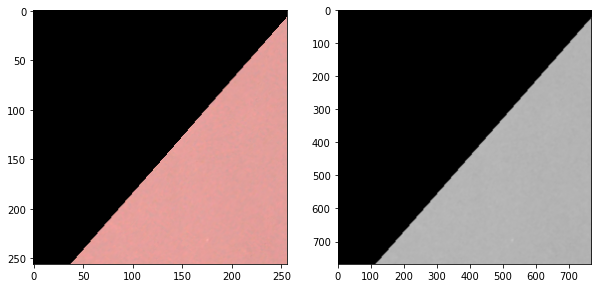

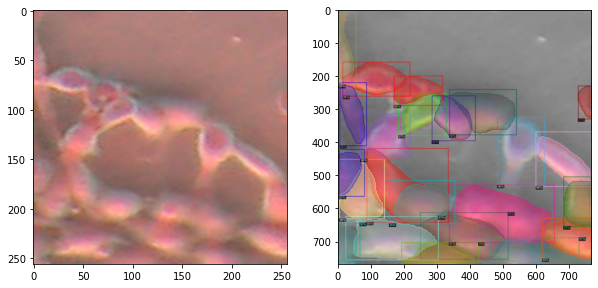

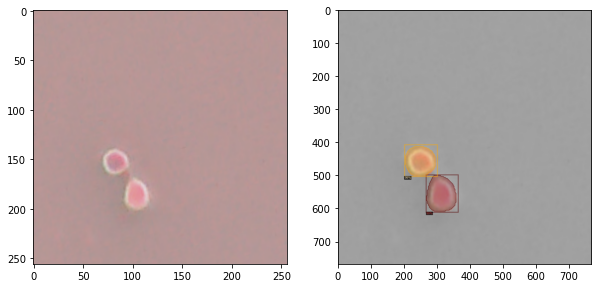

In [58]:
for d in random.sample(dataset_dicts, 5):    
    im = cv2.imread(d["file_name"])
    outputs = predictor(im)
    v = Visualizer(im[:, :, ::-1],
                   metadata=cell_metadata, 
                   scale=3.0, 
                   instance_mode=ColorMode.IMAGE_BW   # remove the colors of unsegmented pixels
    )
    v = v.draw_instance_predictions(outputs["instances"].to("cpu"))
    
    fig, (ax_l, ax_r) = plt.subplots(1, 2, figsize=(10, 20))
    ax_l.imshow(im)
    ax_r.imshow(v.get_image()[:, :, ::-1])
    plt.show()